# Understanding Regression Parameters

This section of notes aims to dig a bit more into what the simple linear regression (ie., regression with a single continuous covariate/attribute) parameter estimates mean. We will consider the estimation formulas in part of this to gain a sense of how these can be computed. 

## New Example Data
The new data for this section of notes will explore data from the [Environmental Protection Agency on Air Quality](https://www.epa.gov/outdoor-air-quality-data) collected for the state of Iowa in 2021. The data are daily values for PM 2.5 particulates. The attributes included in the data are shown below with a short description.

| Variable | Description | 
|:---------|:------------|
| date      | Date of observation |
| id | Site ID |
| poc | Parameter Occurrence Code (POC) |
| pm2.5 | Average daily pm 2.5 particulate value, in (ug/m3; micrograms per meter cubed) |
| daily_aqi | Average air quality index |
| site_name | Site Name |
| aqs_parameter_desc | Text Description of Observation |
| cbsa_code | Core Based Statistical Area (CBSA) ID |
| cbsa_name | CBSA Name |
| county | County in Iowa |
| avg_wind | Average daily wind speed (in knots) | 
| max_wind | Maximum daily wind speed (in knots) | 
| max_wind_hours | Time of maximum daily wind speed |


### Guiding Question
How is average daily wind speed related to the daily air quality index?

## Bivariate Figure

Note, below I do a bit of post-processing to combine data from different POC values within a single CBSA.

In [2]:
library(tidyverse)
library(ggformula)
library(mosaic)

theme_set(theme_bw(base_size = 18))

airquality <- readr::read_csv("https://raw.githubusercontent.com/lebebr01/psqf_6243/main/data/iowa_air_quality_2021.csv")
wind <- readr::read_csv("https://raw.githubusercontent.com/lebebr01/psqf_6243/main/data/daily_WIND_2021-iowa.csv")

airquality <- airquality %>%
   left_join(wind, by = c('cbsa_name', 'date')) %>% 
   drop_na()

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.8     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: ggstance


Attaching package: 'ggstance'


The following objects are masked from 'package:ggplot2':

    GeomErrorbarh, geom_errorbarh


Loading required package: scales


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


Loading required package: ggridges


New to ggformula?  Try the tutorials: 
	learnr::run_tutorial("introduction", package = "ggformula")
	learnr::run_tutorial("refining", package = "ggformula")

Registered S3 method overwritten by 'mosaic':
  method 

In [3]:
head(airquality)
dim(airquality)

date,id,poc,pm2.5,daily_aqi,site_name,aqs_parameter_desc,cbsa_code,cbsa_name,county,avg_wind,max_wind,max_wind_hours
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1/1/21,190130009,1,15.1,57,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,2.941667,5.8,17
1/4/21,190130009,1,13.3,54,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,2.445833,3.6,20
1/7/21,190130009,1,20.5,69,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,1.995833,3.1,13
1/10/21,190130009,1,14.3,56,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,3.445833,5.0,1
1/13/21,190130009,1,13.7,54,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,1.116667,2.5,15
1/16/21,190130009,1,5.3,22,Water Tower,PM2.5 - Local Conditions,47940,"Waterloo-Cedar Falls, IA",Black Hawk,6.091667,8.9,5


[1] 4821   13

`geom_smooth()` using method = 'gam'



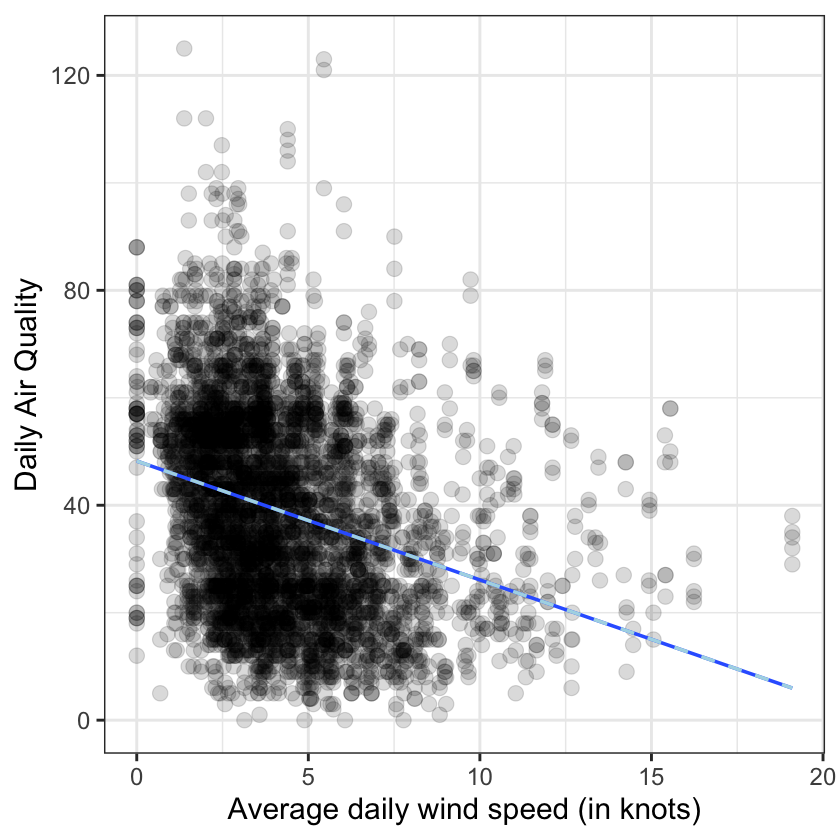

In [4]:
gf_point(daily_aqi ~ avg_wind, data = airquality, size = 4, alpha = .15) %>%
  gf_labs(x = "Average daily wind speed (in knots)",
          y = "Daily Air Quality") %>%
  gf_smooth() %>%
  gf_smooth(method = 'lm', color = 'lightblue', linetype = 2)


In [5]:
cor(daily_aqi ~ avg_wind, data = airquality) |> round(3)

[1] -0.2920277

In [7]:
air_lm <- lm(daily_aqi ~ avg_wind, data = airquality)
coef(air_lm) |> round(3)
summary(air_lm)$r.square |> round(3)
summary(air_lm)$sigma |> round(3)

(Intercept)    avg_wind 
     48.223      -2.212

[1] 0.085

[1] 18.055

### Interpreting these estimates

What do these parameter estimates mean in this context?

**Intercept:** This is the model implied daily air quality when the average wind speed equals 0.
**Slope:** This is the 

## Centering predictors

There are times when centering of predictors can be helpful for interpretation of the model parameters. This can be helpful when 0 is not a practically useful characteristic of the attribute or for more specific tests of certain elements of the X attribute. 

### Mean Centering

Mean centering is where the mean of the attribute is subtracted from each value. This is a linear transformation where each data point is subtracted by a constant, the mean. This means that the distance between points do not change.

In [ ]:
airquality <- airquality %>%
  mutate(avg_wind_mc = avg_wind - mean(avg_wind),
         avg_wind_maxc = avg_wind - max(avg_wind),
         avg_wind_10 = avg_wind - 10)

gf_point(daily_aqi ~ avg_wind_mc, data = airquality, size = 4, alpha = .15) %>%
  gf_labs(x = "Average daily wind speed (in knots)",
          y = "Daily Air Quality") %>%
  gf_smooth() %>%
  gf_smooth(method = 'lm', color = 'lightblue', linetype = 2)

In [ ]:
air_lm_mc <- lm(daily_aqi ~ avg_wind_mc, data = airquality)
coef(air_lm_mc)
summary(air_lm_mc)$r.square
summary(air_lm_mc)$sigma

In [ ]:
air_lm_maxc <- lm(daily_aqi ~ avg_wind_maxc, data = airquality)
coef(air_lm_maxc)
summary(air_lm_maxc)$r.square
summary(air_lm_maxc)$sigma

In [ ]:
air_lm_10 <- lm(daily_aqi ~ avg_wind_10, data = airquality)
coef(air_lm_10)
summary(air_lm_10)$r.square
summary(air_lm_10)$sigma

## Standardized Regression

Another type of regression that can be done is one in which the attributes are standardized prior to estimating the linear regression. What is meant by standardizing? This is converting the attributes into z-scores:

$$ 
Z_{api} = \frac{(aqi - \bar{aqi})}{s_{aqi}}
$$

In [ ]:
airquality <- airquality %>%
  mutate(z_aqi = scale(daily_aqi),
         z_aqi2 = (daily_aqi - mean(daily_aqi)) / sd(daily_aqi),
         z_wind = scale(avg_wind))

head(airquality)

In [ ]:
air_lm_s <- lm(z_aqi ~ z_wind, data = airquality)
coef(air_lm_s)
summary(air_lm_s)$r.square
summary(air_lm_s)$sigma

We can also use this formula to convert any unstandardized regression coefficients into a standardized metric. 

$$ 
b^{'}_{k} = b_{k} * \frac{s_{x_{k}}}{s_{y}}
$$

In [ ]:
-2.211 * sd(airquality$avg_wind) / sd(airquality$daily_aqi)
cor(daily_aqi ~ avg_wind, data = airquality)

## Parameter Estimation

Now that we looked how the parameters are impacted by some changes in the model specification, how are these parameters actually estimated? I will show two ways, one is general, the other is specific to this simple case with a single predictor/covariate attribute. In general, linear regression (or more generally the general linear model) uses least square estimation. This means that the the parameters in the model minimize the squared distance between the observed and predicted values. That is, least squares estimates minimize this criterion:

$$
\sum (Y - \hat{Y})^2
$$

### Specific example
Calculus can be used to show that these two equations can be solved simultanuously to get estimates for $\beta_{0}$ and $\beta_{1}$ that minimize the criterion above. These formulas are:

$$
b_{1} = \frac{\sum(X - \bar{X})(Y - \bar{Y})}{\sum(X - \bar{X})^2}
$$
$$
b_{0} = \bar{Y} - b_{1}\bar{X}
$$

Let's use R to get these quantities.

In [ ]:
b1 <- with(airquality, 
      sum((avg_wind - mean(avg_wind)) * (daily_aqi - mean(daily_aqi))) / sum((avg_wind - mean(avg_wind))^2)
)
b0 <- with(airquality, 
      mean(daily_aqi) - b1 * mean(avg_wind)
)
b0
b1
coef(air_lm)

### General Approach

When there are more than one predictor, the number of equations gets a bit unyieldy, therefore, there is a general analytic approach that works for any set of predictor attributes. The general approach uses matrix algebra (anyone take linear algebra?), to achieve their estimates. This general form is:

$$
\mathbf{b} = \left( \mathbf{X}^{`}\mathbf{X} \right)^{-1} \left( \mathbf{X}^{`} \mathbf{Y} \right).
$$
Where $\mathbf{b}$ is a vector of estimated regression coefficients, $\mathbf{X}$ is a matrix of covariate/predictor attributes (called the design matrix), and $\mathbf{Y}$ is a vector of the outcome attribute. 

Below, I show what these would look like for the air quality example that has been used and solve for the regression coefficients.

In [ ]:
X <- model.matrix(air_lm)
head(X)

In [ ]:
Y <- as.matrix(airquality$daily_aqi)
head(Y)

In [ ]:
X_X <- solve(t(X) %*% X)
X_X

In [ ]:
X_Y <- t(X) %*% Y
X_Y

In [ ]:
X_X %*% X_Y
coef(air_lm)